# About
This notebook calculates the proteome-wide analyses (panels B-G in Fig. 3)

In [1]:
import numpy as np
import matplotlib
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
import protfasta

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list,fcluster
import matplotlib.patches as mpatches

import itertools
import metapredict as meta

from shephard.interfaces import si_proteins, si_protein_attributes,si_domains
from shephard import Proteome

from scipy.stats import ttest_ind

def cast_attributes(obj, include=[], exclude=[], cast_type=float):
    if len(include) > 0:
        for a in include:
            if a in obj.attributes:                
                obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
    if len(exclude) > 0:
        for a in obj.attributes:
            if a not in exclude:                
                obj.add_attribute(a, cast_type(obj.attribute(a)), safe=False)
                

def peval(pval,n=1):
    if pval < 0.00001/n:
        return('****')
    elif pval < 0.0001/n:
        return('***')
    elif pval < 0.001/n:
        return('**')
    elif pval < 0.01/n:
        return('*')
    else:
        return('ns')

# lets you import from the code directory here
local_code_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'code'))

if local_code_path not in sys.path:
    sys.path.append(local_code_path)


from common_functions import annotate_with_quantiles

In [2]:
yp = Proteome()

# read in soluble proteins only
si_proteins.add_proteins_from_file(yp,'../data/experimental_data/shprd_proteome_soluble_only_v2.tsv')

# annotate with IDRs
si_domains.add_domain_attributes_from_file(yp,'../data/shprd_files/shprd_yeast_idrs.tsv')

# annotate with abundance
si_protein_attributes.add_protein_attributes_from_file(yp, '../data/shprd_files/shprd_yeast_copynumber_ghaemmaghami.tsv')

# annotate with interactome data
si_protein_attributes.add_protein_attributes_from_file(yp, '../data/shprd_files/shprd_interactome.tsv')

# annotate with domain data (CHAINSAW)
si_domains.add_domains_from_file(yp, '../data/shprd_files/shprd_chainsaw_domains_0.4.tsv')

# annotate with domain data (DODO) - called 'globular_shprd'
si_domains.add_domains_from_file(yp, '../data/shprd_files/shprd_dodo_domains_0.4.tsv')


# cast protein attributes 
for p in yp:
    cast_attributes(p, exclude=['partners', 'lip_color', 'non_ref_score', 'non_ref','refoldable', 'nonrefoldable','membrane_protein', 'subcellular_localization'])

# annotate every protein 
quantiles = annotate_with_quantiles(yp,proteins_with_domains=False)

Sanity check number of proteins in each group
[404, 404, 403, 403, 403, 403, 403, 403]


# Protein length

In [3]:

# quantify
quant2length = {}
for p in yp:
    
    q = p.attribute('quantile')
    if q not in quant2length:
        quant2length[q] = []
    quant2length[q].append(len(p))

quant2length_scores = dict(sorted(quant2length.items(), key=lambda item: item[0], reverse=False))
quant2length_mean_scores = []

for q in quantiles:
    quant2length_mean_scores.append(np.mean(quant2length_scores[q]))
    

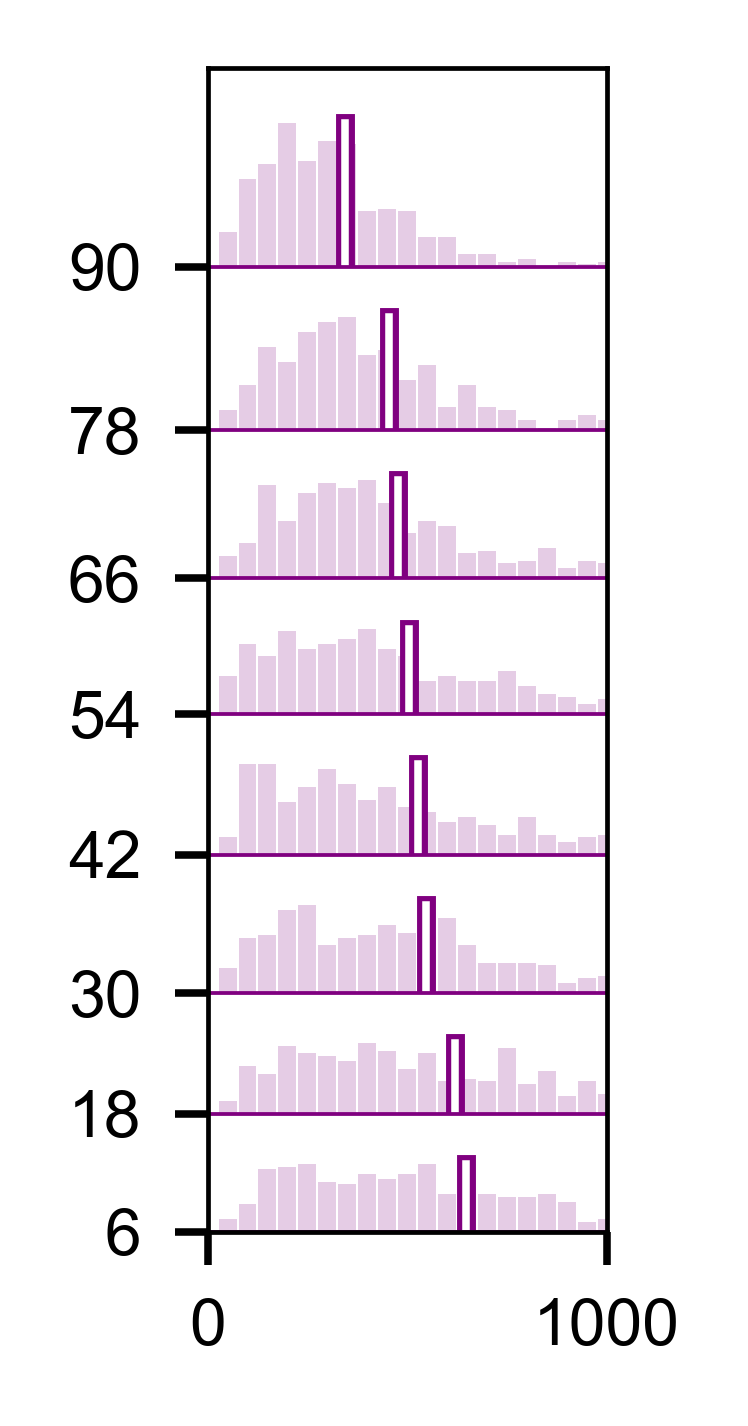

In [5]:
bin_size = 50
bin_end = 20000
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'purple'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = quant2length_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.mean(s)
    plt.plot([average_val, average_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0,1000])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures/protein_length_bar.pdf')

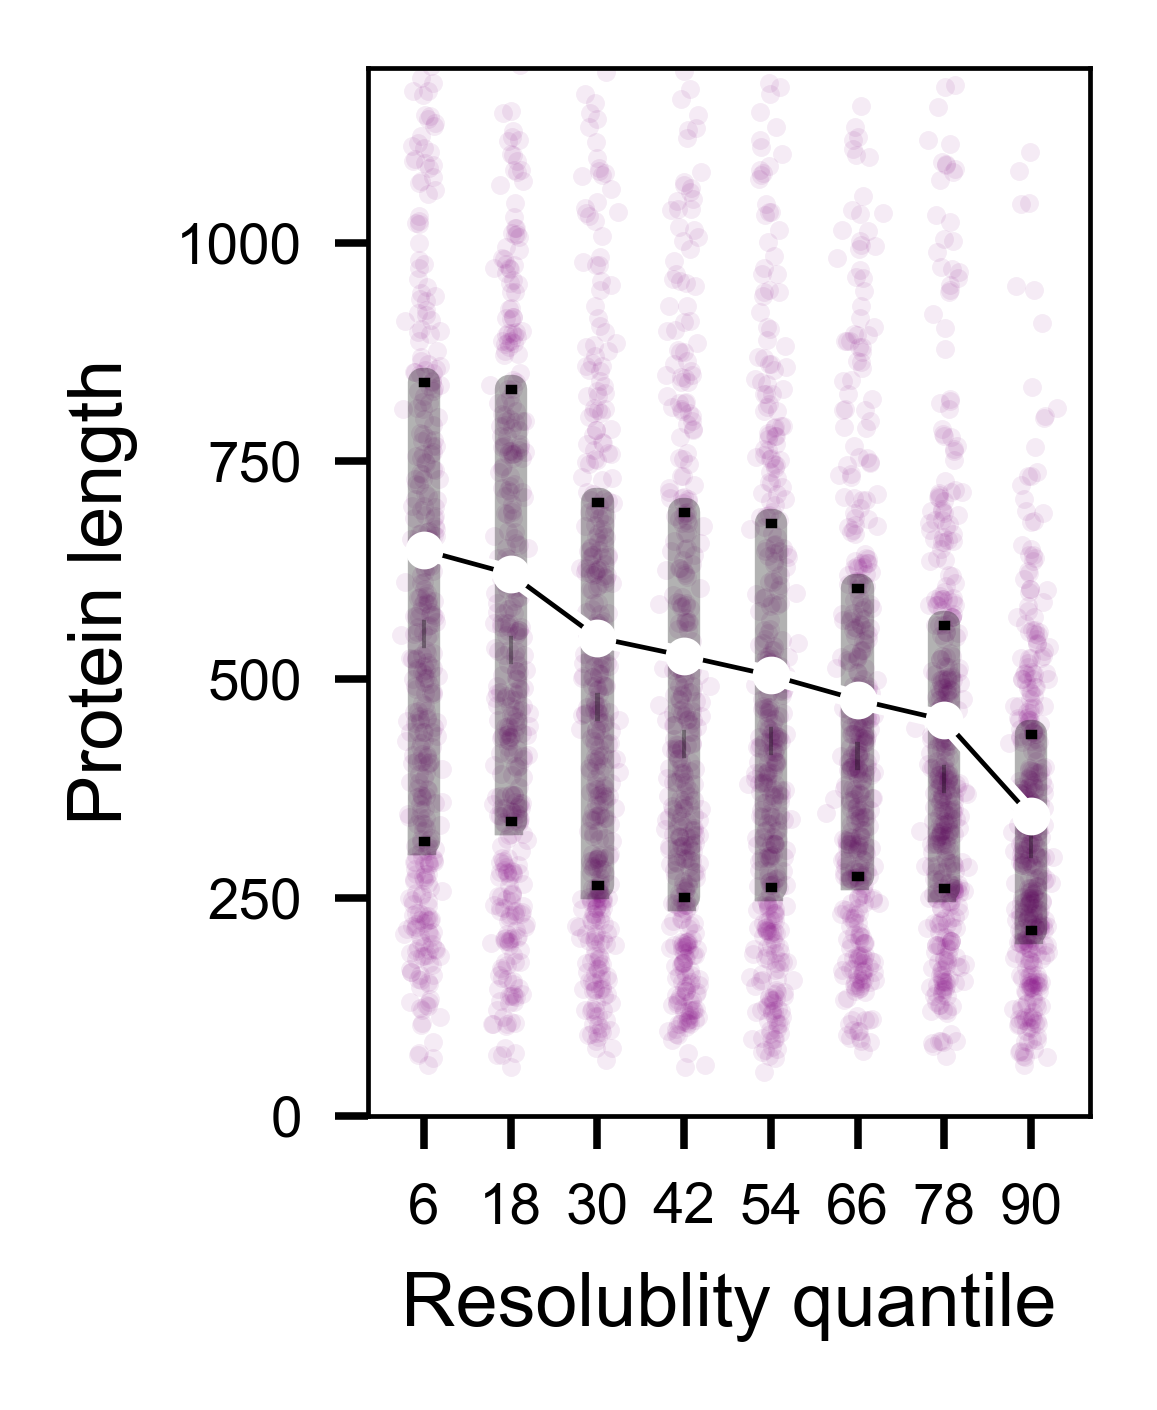

In [29]:
color='purple'
figure(None, (1.8,2.2), dpi=340)
boxprops = dict(linewidth=3,alpha=0.3, color='k')

plt.plot(quantiles, quant2length_mean_scores,color='w',lw=2,zorder=20)
plt.plot(quantiles, quant2length_mean_scores,color='k',lw=0.5,zorder=20)

all_s = []
for idx, name in enumerate(quantiles):
    s = quant2length_scores[name]
    pos = quantiles[idx]
    scatter_pos = np.random.randn(len(s))*1.1+pos
    plt.scatter(scatter_pos, s, s=4, alpha=0.08, c=color,linewidth=0)

    b = plt.boxplot(s, positions=[pos],widths=[0.6],showfliers=False, whis=0, boxprops=boxprops,medianprops=boxprops, )
    all_s.extend(s)
plt.ylim([0,1200])   
plt.yticks(fontsize=7)
plt.ylabel('Protein length', fontsize=8)
plt.xlabel('Resolublity quantile', fontsize=8)

plt.plot(quantiles, quant2length_mean_scores,'o',color='w', zorder=20,ms=3)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()

# Protein abundance

In [6]:
# quantify
quant2abundance = {}

all_cn = []
all_abundance_quant = []
for p in yp:
    
    if 'copy_number' not in p.attributes:
        continue

    all_cn.append(p.attribute('copy_number'))
    all_abundance_quant.append(p.attribute('S_over_T_mean'))
    
    
    q = p.attribute('quantile')
    if q not in quant2abundance:
        quant2abundance[q] = []
    quant2abundance[q].append(p.attribute('copy_number'))

quant2abundance_scores = dict(sorted(quant2abundance.items(), key=lambda item: item[0], reverse=False))
quant2abundance_mean_scores = []

for q in quantiles:
    quant2abundance_mean_scores.append(np.median(quant2abundance_scores[q]))



Bounds of 100 and 10000 encompase 82.26% of the proteome


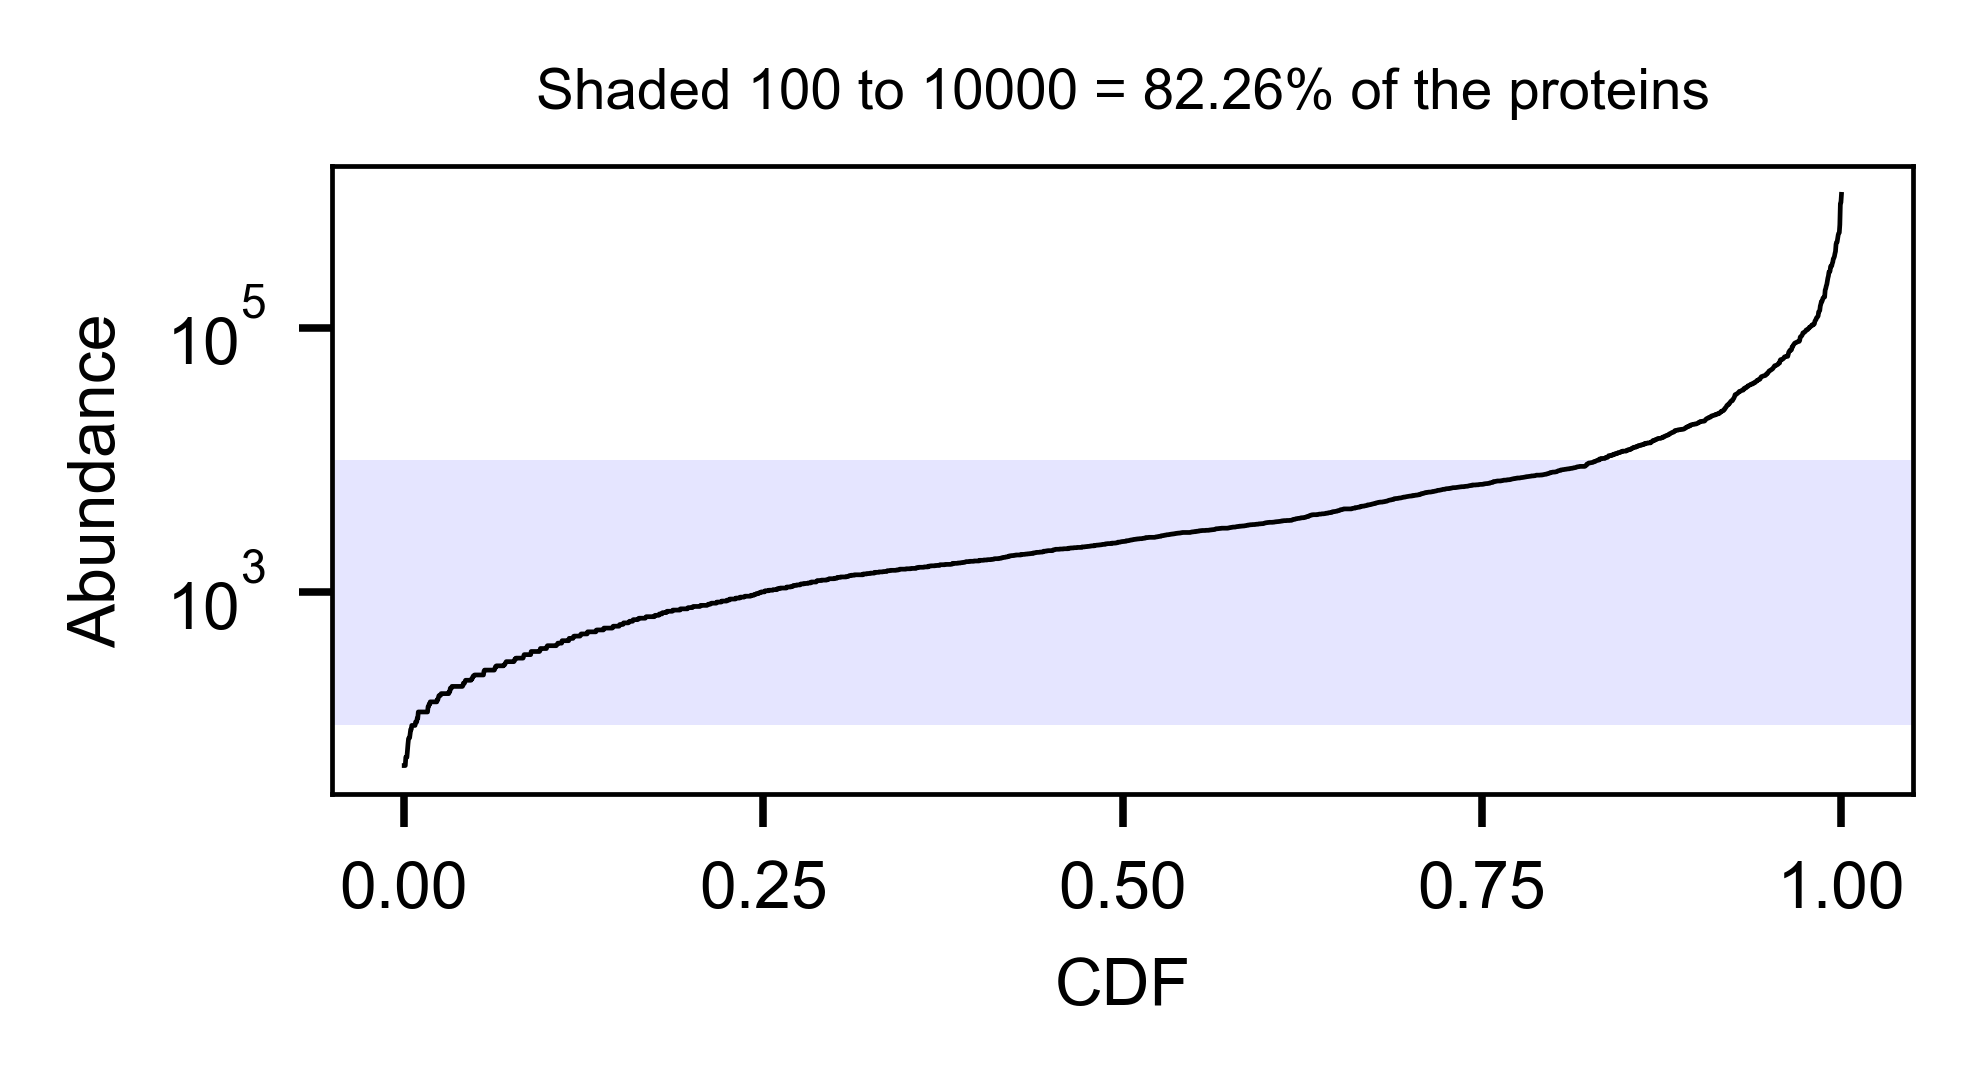

In [144]:
figure(None, (3,1.2), dpi=340)
min_abun = 100
max_abun = 10000
ax = plt.gca()
all_cn.sort()
cdf = np.arange(1, len(all_cn)+1) / len(all_cn)

plt.plot(cdf,all_cn, lw=0.5, color='k')
plt.yscale('log')
ax.axhspan(min_abun, max_abun, alpha=0.1, color='b', lw=0)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('CDF',fontsize=7)
plt.ylabel('Abundance',fontsize=7)

#plt.yticks(np.logspace(min_abun,max_abun, int(np.ceil(np.log10(max_abun)-np.log10(min_abun)))))

fraction_encompassed = np.sum((np.array(all_cn) > min_abun) & (np.array(all_cn) < max_abun))/len(all_cn)
plt.title(f'Shaded {min_abun} to {max_abun} = {round(fraction_encompassed*100,2)}% of the proteins', fontsize=6)
print(f'Bounds of {min_abun} and {max_abun} encompase {round(fraction_encompassed*100,2)}% of the proteome')


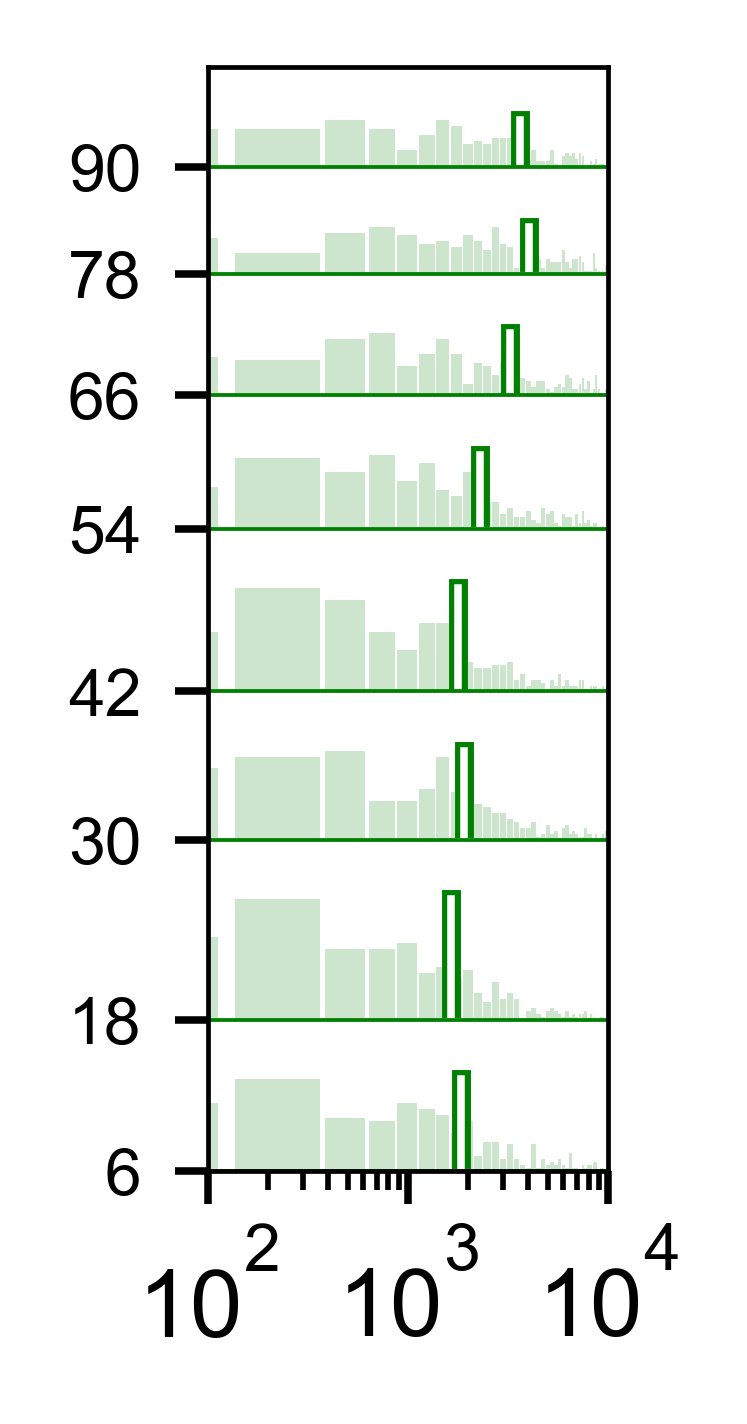

In [146]:
bin_size = 250
# we use 200,000 as end bin because ~99% of proteins are found at
# an abundance lower than 200,000 copies per cell
bin_end = 200000
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'green'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = quant2abundance_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    med_val = np.median(s)
    plt.plot([med_val, med_val], [offset+lw*2, offset+max(X[0])],color=color,lw=lw)
    plt.plot([med_val, med_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    


plt.xlim([min_abun,max_abun])
plt.xscale('log')
plt.yticks(ytix, quantiles,fontsize=7)
#plt.xticks([100,1000,10000,100000],[100,1000,10000,100000], fontsize=5, rotation=90)
plt.tight_layout()
plt.savefig('outfigures/protein_abundance_bar.pdf')

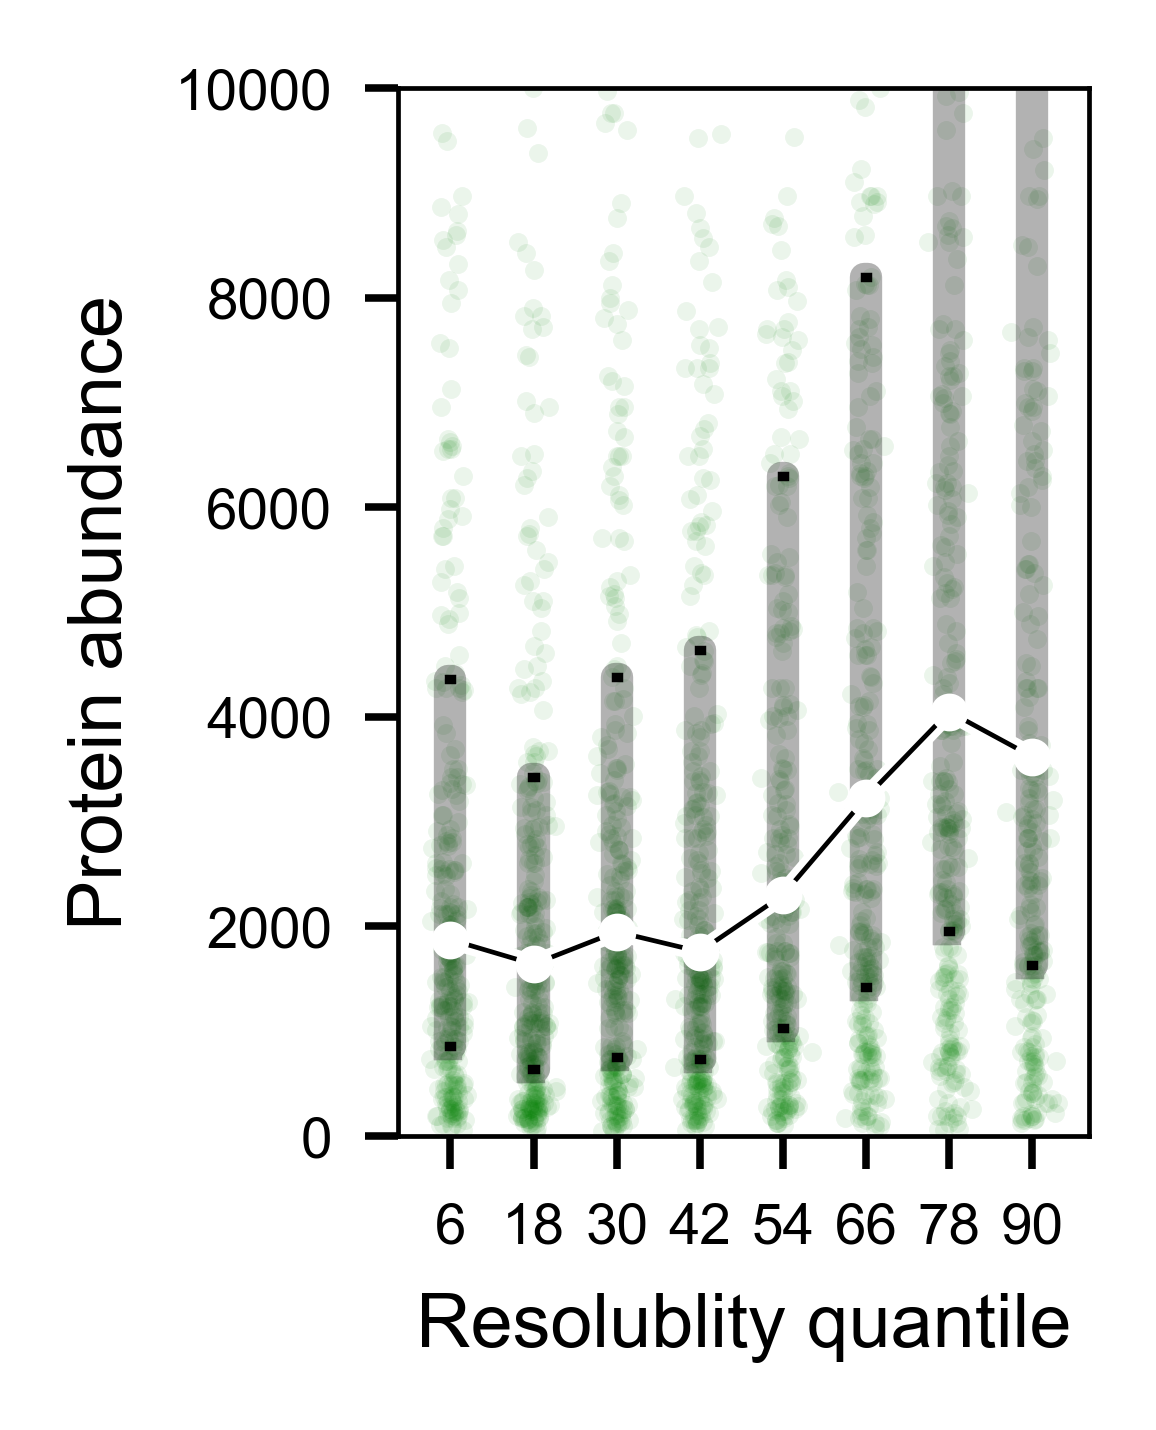

In [28]:
color='green'
figure(None, (1.8,2.2), dpi=340)
boxprops = dict(linewidth=3,alpha=0.3, color='k')

plt.plot(quantiles, quant2abundance_mean_scores,color='w',lw=2,zorder=20)
plt.plot(quantiles, quant2abundance_mean_scores,color='k',lw=0.5,zorder=20)

all_s = []
for idx, name in enumerate(quantiles):
    s = quant2abundance_scores[name]
    pos = quantiles[idx]
    scatter_pos = np.random.randn(len(s))*1.1+pos
    plt.scatter(scatter_pos, s, s=4, alpha=0.08, c=color,linewidth=0)

    b = plt.boxplot(s, positions=[pos],widths=[0.6],showfliers=False, whis=0, boxprops=boxprops,medianprops=boxprops, )
    all_s.extend(s)
plt.ylim([0,10000])   
plt.yticks(fontsize=7)
plt.ylabel('Protein abundance', fontsize=8)
plt.xlabel('Resolublity quantile', fontsize=8)

plt.plot(quantiles, quant2abundance_mean_scores,'o',color='w', zorder=20,ms=3)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()

# Protein disorder

In [23]:
for p in yp:
    # calculate fraction disordered
    num_disordered_res = np.sum([len(d) for d in p.domains if d.domain_type == 'IDR'])
    fraction_dis = num_disordered_res/len(p)
    p.add_attribute('fraction_disordered', fraction_dis, safe=False)
    p.add_attribute('num_disordered_res', num_disordered_res, safe=False)



In [24]:
# quantify
quant2disorder = {}
for p in yp:
    
    q = p.attribute('quantile')
    if q not in quant2disorder:
        quant2disorder[q] = []
    quant2disorder[q].append(p.attribute('fraction_disordered'))

quant2disorder_scores = dict(sorted(quant2disorder.items(), key=lambda item: item[0], reverse=False))
quant2disorder_mean_scores = []
quant2disorder_median_scores = []

for q in quantiles:
    quant2disorder_mean_scores.append(np.mean(quant2disorder_scores[q]))
    quant2disorder_median_scores.append(np.median(quant2disorder_scores[q]))
    

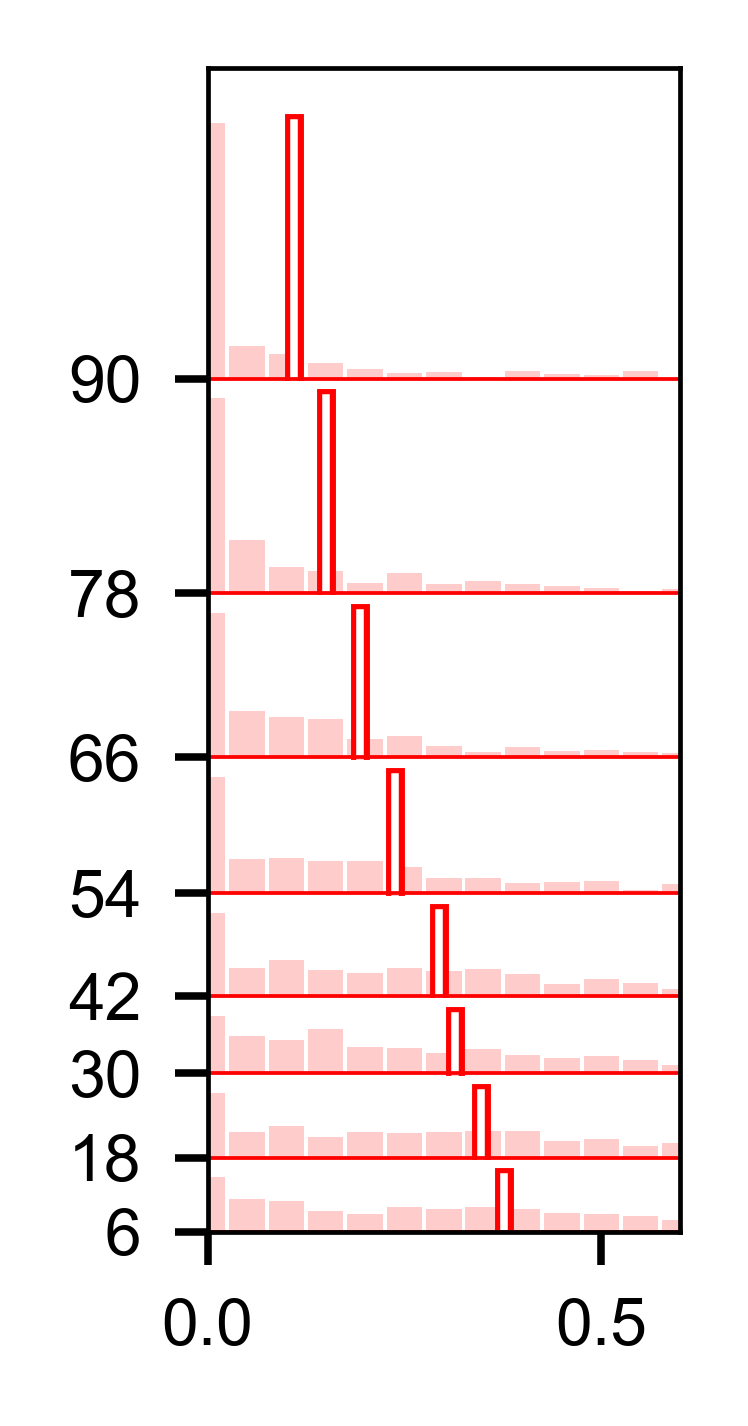

In [25]:
bin_size = 0.05
bin_end = 1
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'red'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = quant2disorder_scores[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.mean(s)
    plt.plot([average_val, average_val], [offset+lw*4, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0,0.6])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures/protein_disorder_bar.pdf')

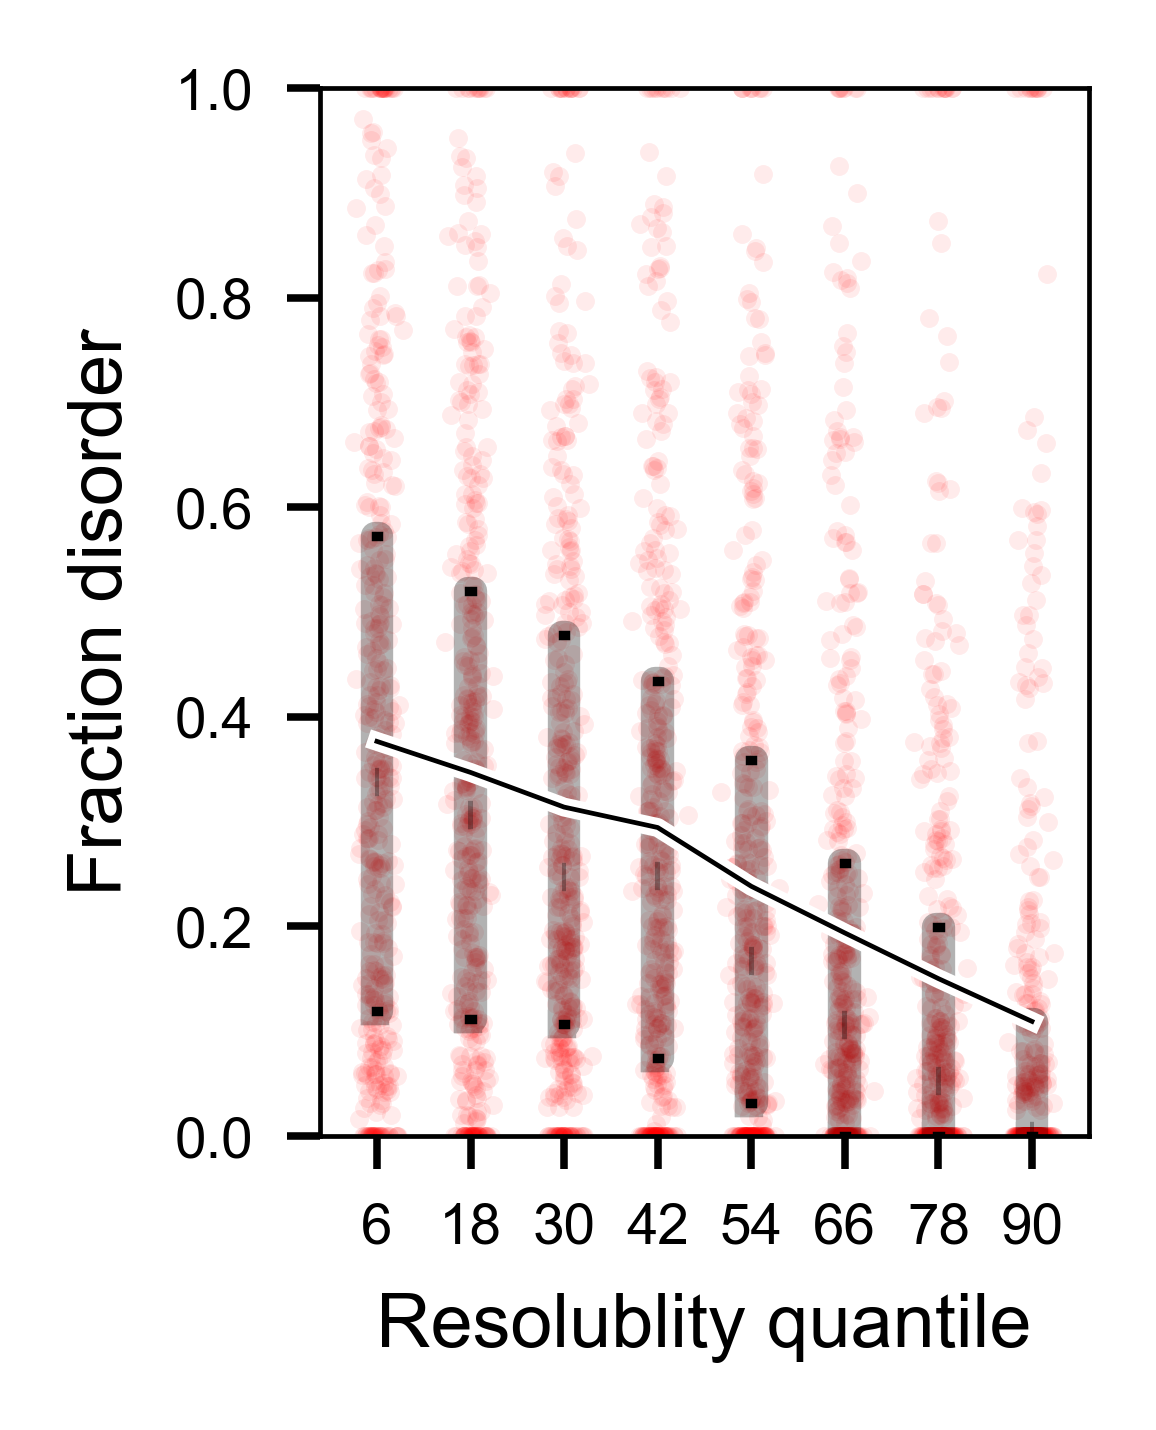

In [27]:
color='red'
figure(None, (1.8,2.2), dpi=340)
boxprops = dict(linewidth=3,alpha=0.3, color='k')

plt.plot(quantiles, quant2disorder_mean_scores,color='w',lw=2,zorder=20)
plt.plot(quantiles, quant2disorder_mean_scores,color='k',lw=0.5,zorder=20)

all_s = []
for idx, name in enumerate(quantiles):
    s = quant2disorder_scores[name]
    pos = quantiles[idx]
    scatter_pos = np.random.randn(len(s))*1.1+pos
    plt.scatter(scatter_pos, s, s=4, alpha=0.08, c=color,linewidth=0)

    b = plt.boxplot(s, positions=[pos],widths=[0.6],showfliers=False, whis=0, boxprops=boxprops,medianprops=boxprops, )
    all_s.extend(s)
plt.ylim([0,1])   
plt.yticks(fontsize=7)
plt.ylabel('Fraction disorder', fontsize=8)
plt.xlabel('Resolublity quantile', fontsize=8)

plt.plot(quantiles, quant2abundance_mean_scores,'o',color='w', zorder=20,ms=3)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()

In [30]:
# quantify
quant2disordered_res = {}
for p in yp:
    
    q = p.attribute('quantile')
    if q not in quant2disordered_res:
        quant2disordered_res[q] = []
    quant2disordered_res[q].append(p.attribute('num_disordered_res'))

quant2disordered_res_scores = dict(sorted(quant2disordered_res.items(), key=lambda item: item[0], reverse=False))
quant2disordered_res_mean_scores = []
quant2disordered_res_median_scores = []

for q in quantiles:
    quant2disordered_res_mean_scores.append(np.mean(quant2disordered_res_scores[q]))
    quant2disordered_res_median_scores.append(np.median(quant2disordered_res_scores[q]))
    

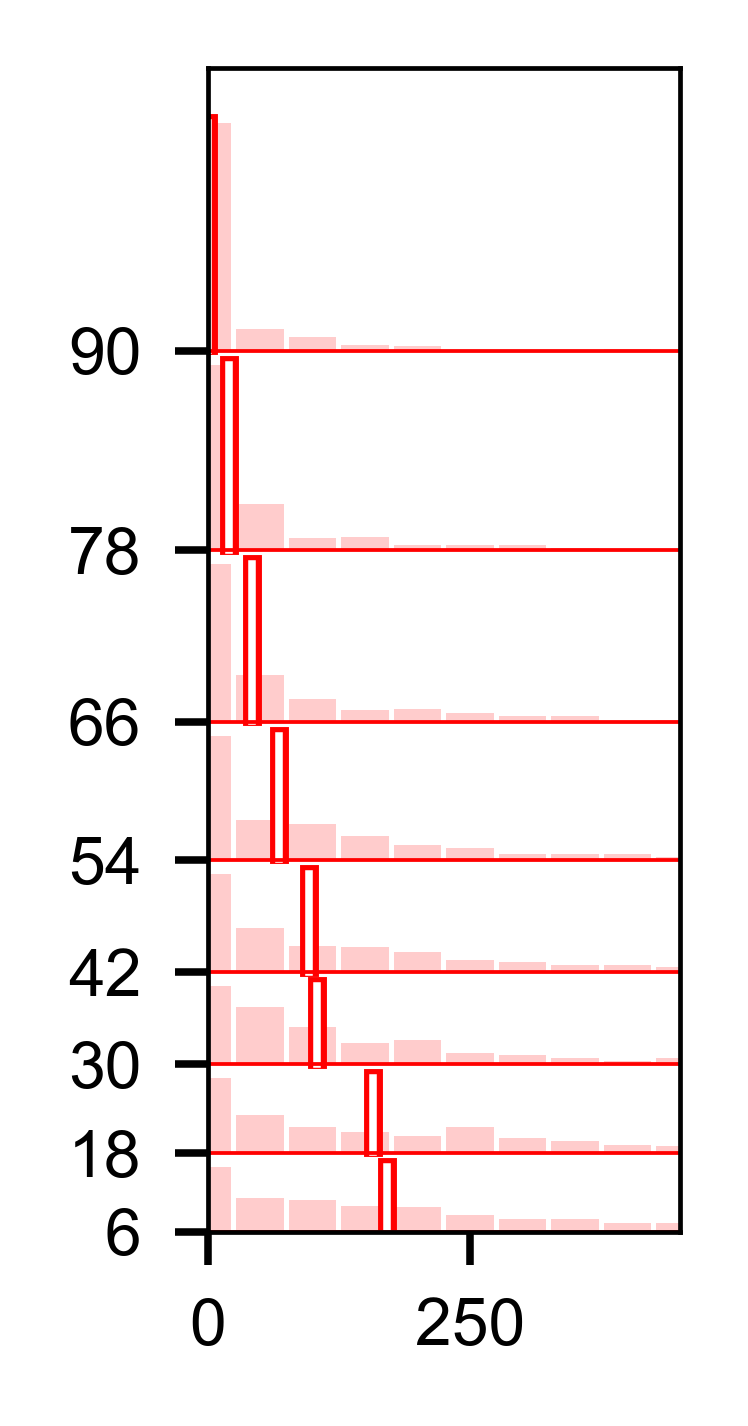

In [31]:
bin_size = 50
bin_end = 500
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'red'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = quant2disordered_res[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*4, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0,450])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()

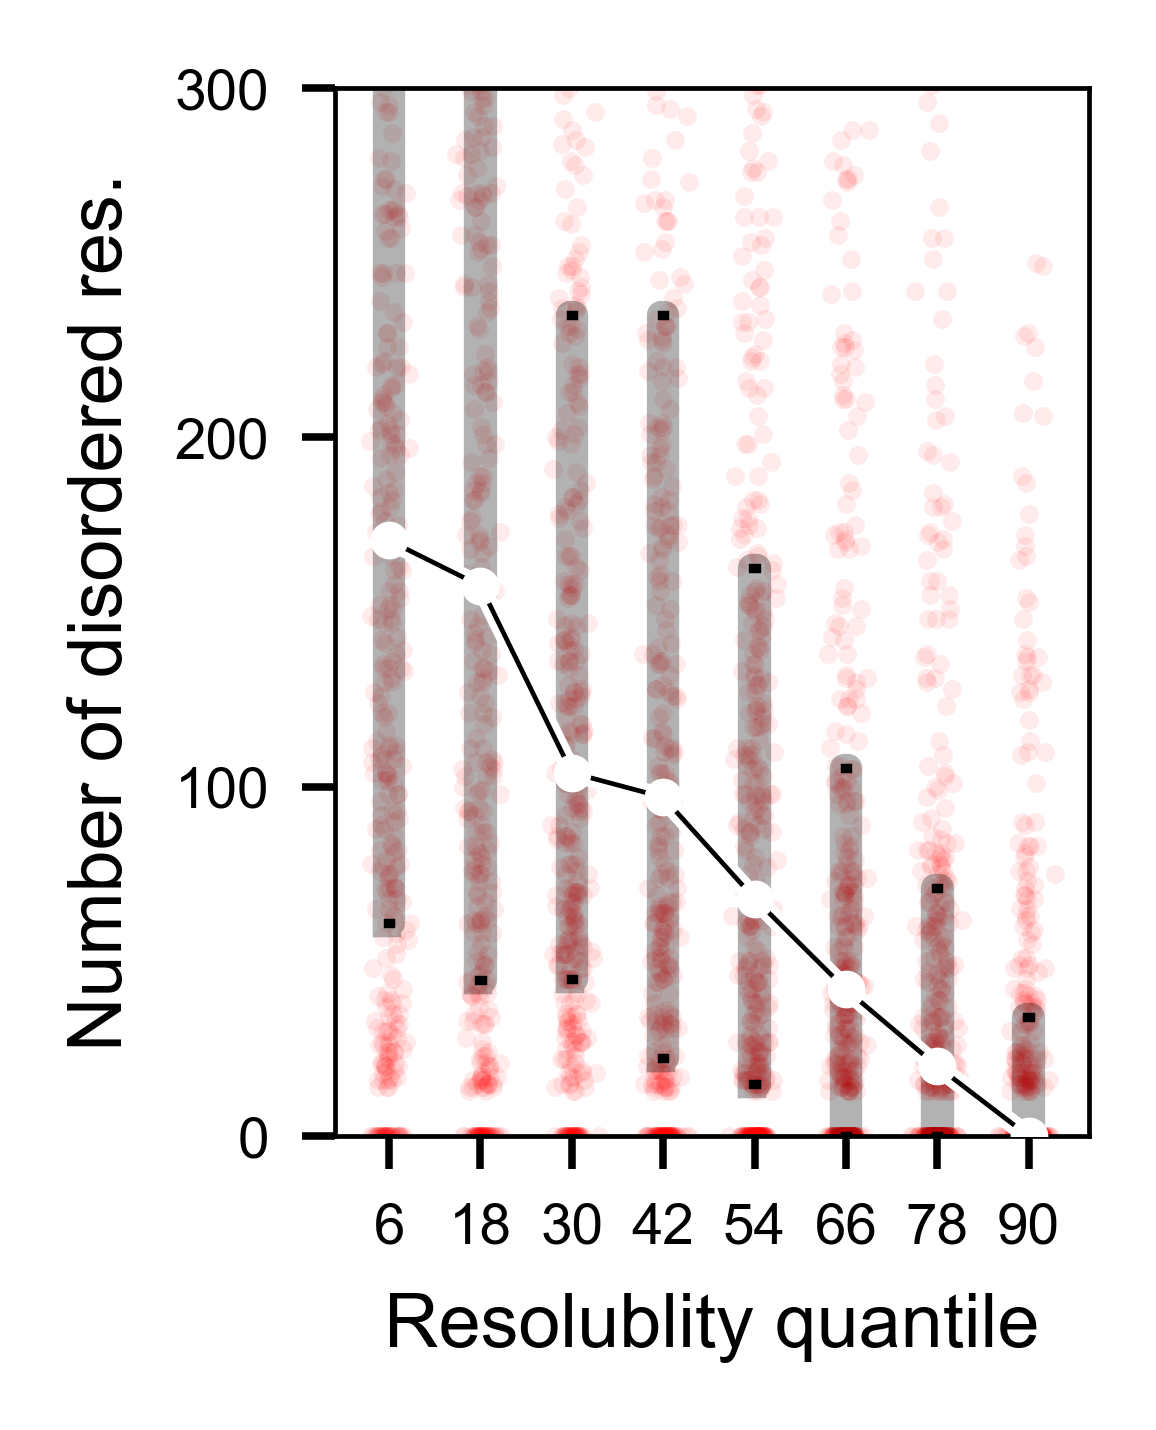

In [32]:
color='red'
figure(None, (1.8,2.2), dpi=340)
boxprops = dict(linewidth=3,alpha=0.3, color='k')

plt.plot(quantiles, quant2disordered_res_median_scores,color='w',lw=2,zorder=20)
plt.plot(quantiles, quant2disordered_res_median_scores,color='k',lw=0.5,zorder=20)

all_s = []
for idx, name in enumerate(quantiles):
    s = quant2disordered_res_scores[name]
    pos = quantiles[idx]
    scatter_pos = np.random.randn(len(s))*1.1+pos
    plt.scatter(scatter_pos, s, s=4, alpha=0.08, c=color,linewidth=0)

    b = plt.boxplot(s, positions=[pos],widths=[0.6],showfliers=False, whis=0, boxprops=boxprops,medianprops=boxprops, )
    all_s.extend(s)
plt.ylim([0,300])   
plt.yticks(fontsize=7)
plt.ylabel('Number of disordered res.', fontsize=8)
plt.xlabel('Resolublity quantile', fontsize=8)

plt.plot(quantiles, quant2disordered_res_median_scores,'o',color='w', zorder=20,ms=3)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()

In [33]:
# quantify
quant2interactors = {}
for p in yp:

    if 'interact_count' not in p.attributes:
        continue
    
    q = p.attribute('quantile')
    if q not in quant2interactors:
        quant2interactors[q] = []
    quant2interactors[q].append(p.attribute('interact_count'))

quant2interactors_scores = dict(sorted(quant2interactors.items(), key=lambda item: item[0], reverse=False))

quant2interactors_mean_scores = []
quant2interactors_median_scores = []

for q in quantiles:
    quant2interactors_mean_scores.append(np.mean(quant2interactors_scores[q]))
    quant2interactors_median_scores.append(np.median(quant2interactors_scores[q]))
    

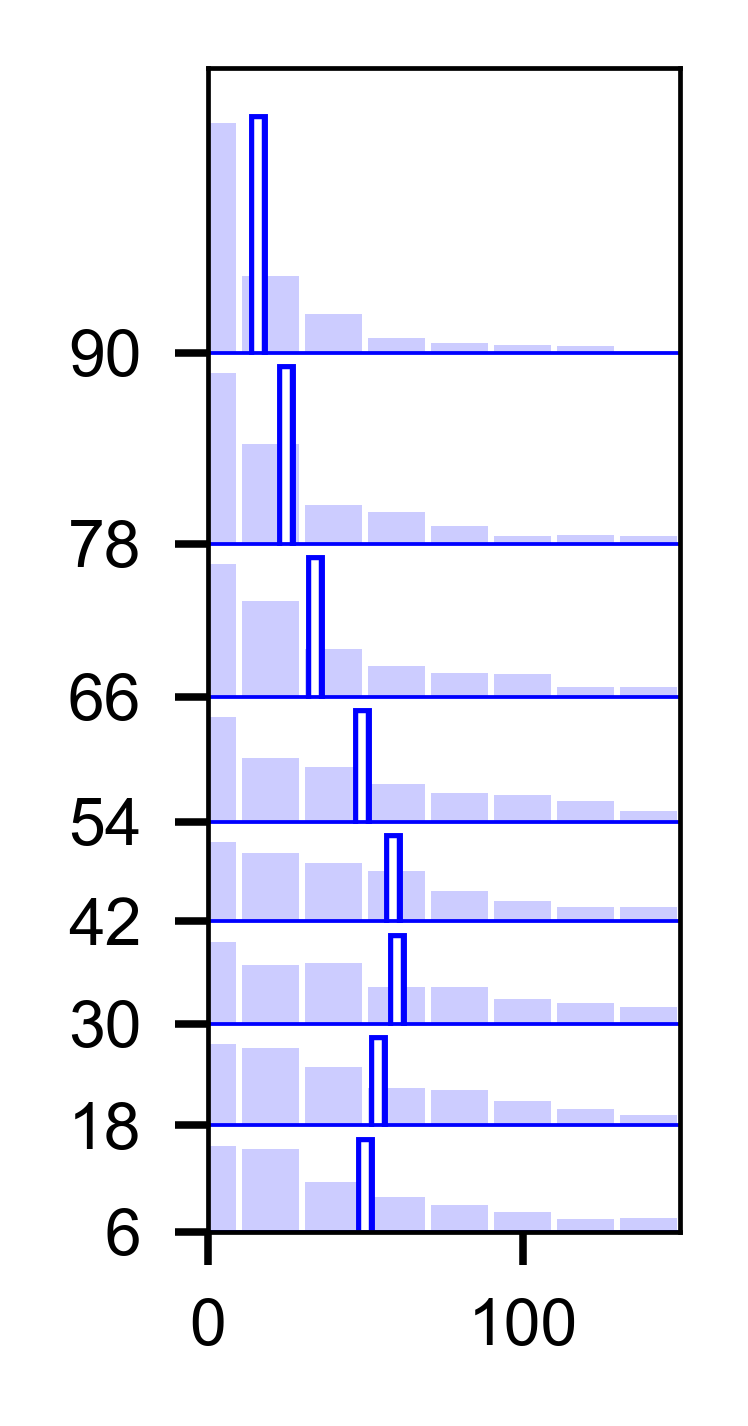

In [36]:
bin_size = 20
bin_end = 500
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'blue'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = quant2interactors[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.median(s)
    plt.plot([average_val, average_val], [offset+lw*4, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
plt.xlim([0,150])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures/protein_interactors_bar.pdf')

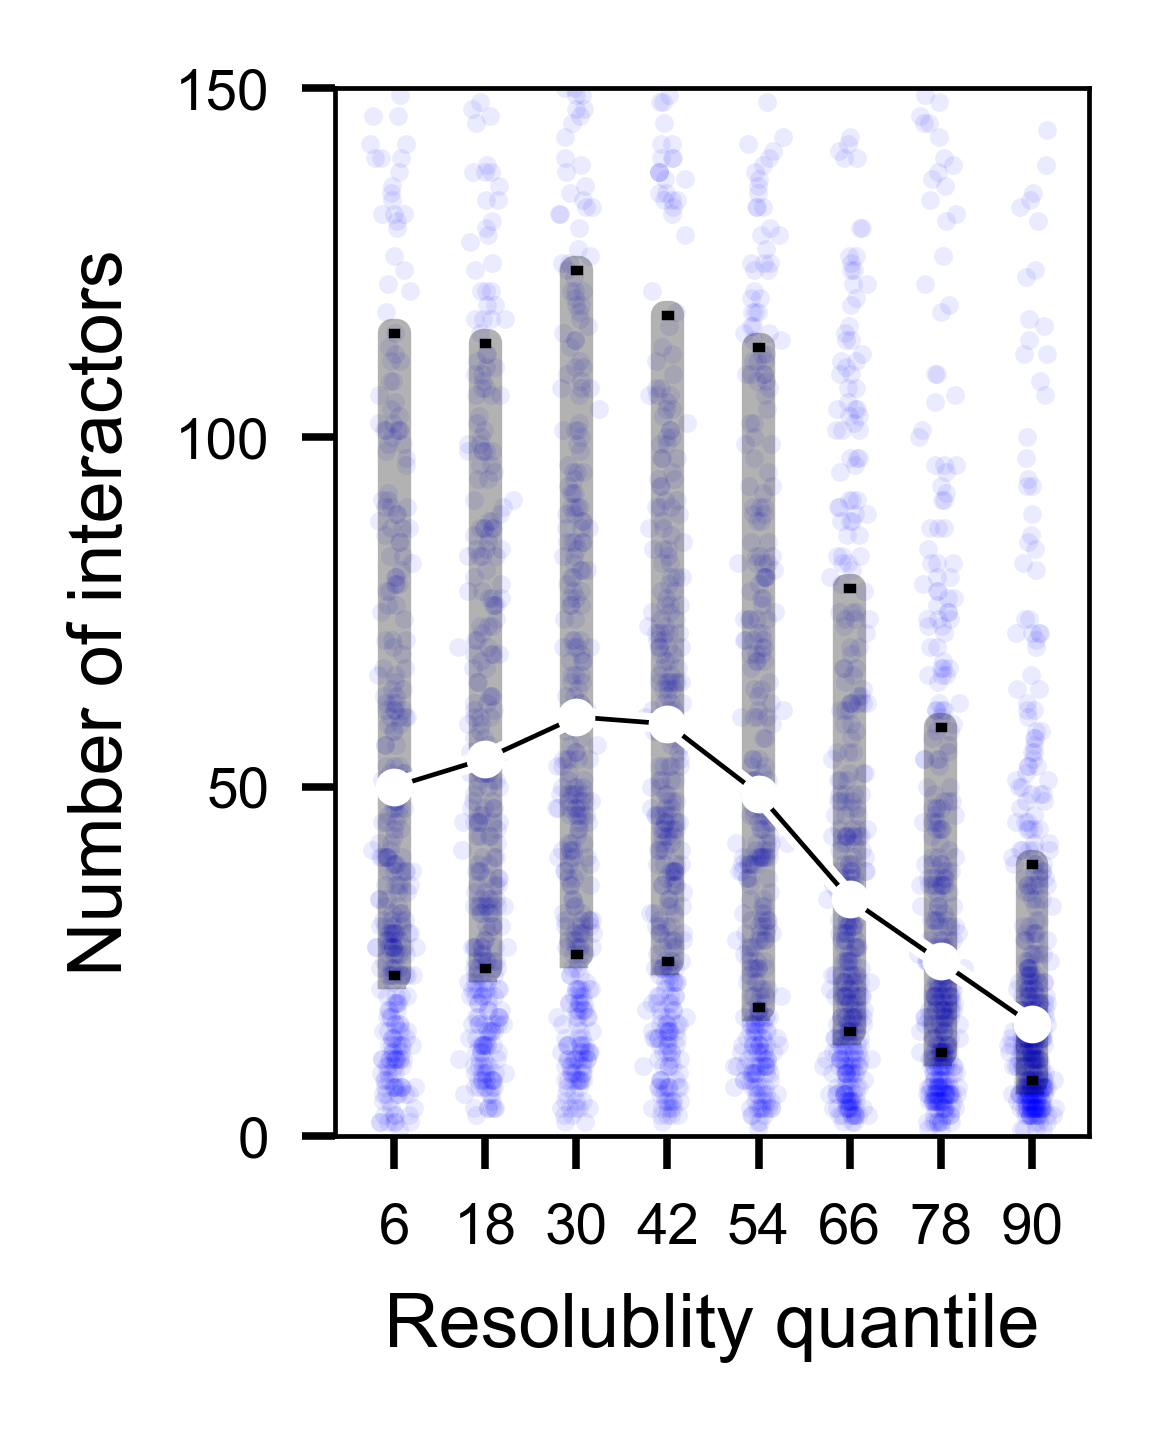

In [37]:
color='blue'
figure(None, (1.8,2.2), dpi=340)
boxprops = dict(linewidth=3,alpha=0.3, color='k')

plt.plot(quantiles, quant2interactors_median_scores,color='w',lw=2,zorder=20)
plt.plot(quantiles, quant2interactors_median_scores,color='k',lw=0.5,zorder=20)

all_s = []
for idx, name in enumerate(quantiles):
    s = quant2interactors_scores[name]
    pos = quantiles[idx]
    scatter_pos = np.random.randn(len(s))*1.1+pos
    plt.scatter(scatter_pos, s, s=4, alpha=0.08, c=color,linewidth=0)

    b = plt.boxplot(s, positions=[pos],widths=[0.6],showfliers=False, whis=0, boxprops=boxprops,medianprops=boxprops, )
    all_s.extend(s)
plt.ylim([0,150])   
plt.yticks(fontsize=7)
plt.ylabel('Number of interactors', fontsize=8)
plt.xlabel('Resolublity quantile', fontsize=8)

plt.plot(quantiles, quant2interactors_median_scores,'o',color='w', zorder=20,ms=3)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()

In [38]:
# quantify
quant2domaincount = {}

# NOTE our domain length threshold here is more permissive than elsewhere (report this in methods!!!)
domain_thresh = 60
total_count = 0
for p in yp:

    count = 0
    for d in p.domains:
        if d.domain_type == 'globular_chainsaw':
            if len(d) > domain_thresh:
                count = count +1
    q = p.attribute('quantile')
    
    total_count = total_count + 1
    
    if q not in quant2domaincount:
        quant2domaincount[q] = []
        
    quant2domaincount[q].append(count)

quant2domaincount_scores = dict(sorted(quant2domaincount.items(), key=lambda item: item[0], reverse=False))

quant2domaincount_mean_scores = []
quant2domaincount_median_scores = []

for q in quantiles:
    quant2domaincount_mean_scores.append(np.mean(quant2domaincount_scores[q]))
    quant2domaincount_median_scores.append(np.median(quant2domaincount_scores[q]))

print(total_count)

3226


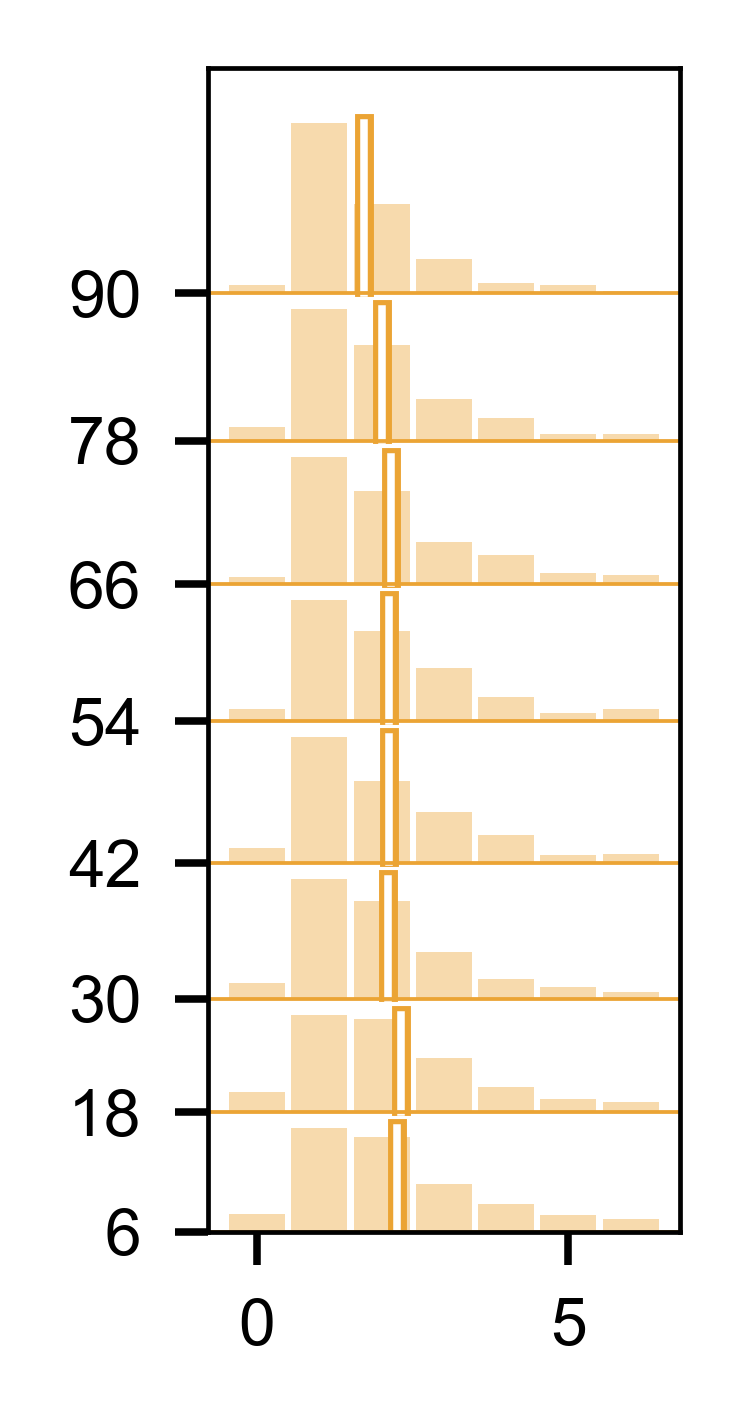

In [39]:
bin_size = 1
bin_end = 7
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = '#eba434'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = quant2domaincount[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.4, color=color)

    average_val = np.mean(s)
    plt.plot([average_val, average_val], [offset+lw*4, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
#plt.xlim([0,150])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()
plt.savefig('outfigures/protein_number_domains_bar.pdf')

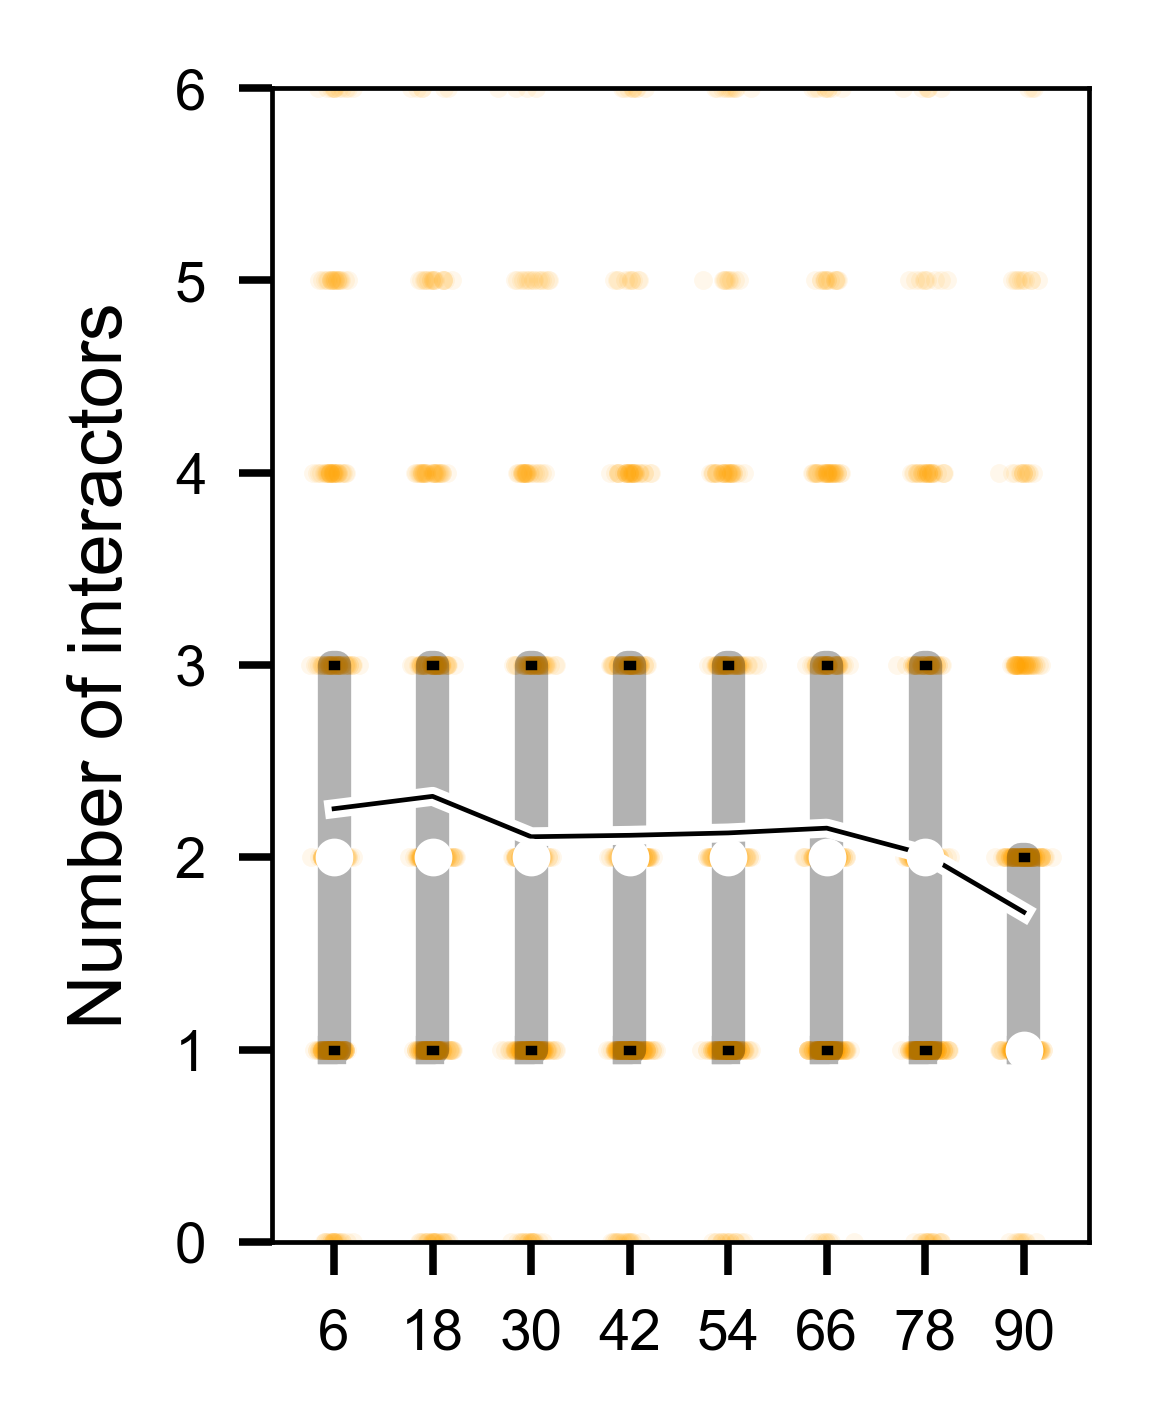

In [40]:
color='orange'
figure(None, (1.8,2.2), dpi=340)
boxprops = dict(linewidth=3,alpha=0.3, color='k')

plt.plot(quantiles, quant2domaincount_mean_scores,color='w',lw=2,zorder=20)
plt.plot(quantiles, quant2domaincount_mean_scores,color='k',lw=0.5,zorder=20)

all_s = []
for idx, name in enumerate(quantiles):
    s = quant2domaincount_scores[name]
    pos = quantiles[idx]
    scatter_pos = np.random.randn(len(s))*1.1+pos
    plt.scatter(scatter_pos, s, s=4, alpha=0.08, c=color,linewidth=0)

    b = plt.boxplot(s, positions=[pos],widths=[0.6],showfliers=False, whis=0, boxprops=boxprops,medianprops=boxprops, )
    all_s.extend(s)
plt.ylim([0,6])   
plt.yticks(fontsize=7)
plt.ylabel('Number of interactors', fontsize=8)

plt.plot(quantiles, quant2domaincount_median_scores,'o',color='w', zorder=20,ms=3)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()

In [42]:
# quantify
quant2domaincount_dodo = {}

# same thres as elsewhere
domain_thresh = 150
total_count = 0
for p in yp:

    count = 0
    for d in p.domains:
        if d.domain_type == 'globular_shprd':
            if len(d) > domain_thresh:
                count = count +1
    q = p.attribute('quantile')
    total_count=total_count+1
    if q not in quant2domaincount_dodo:
        quant2domaincount_dodo[q] = []
    quant2domaincount_dodo[q].append(count)

quant2domaincount_dodo_scores = dict(sorted(quant2domaincount_dodo.items(), key=lambda item: item[0], reverse=False))

quant2domaincount_dodo_mean_scores = []
quant2domaincount_dodo_median_scores = []

for q in quantiles:
    quant2domaincount_dodo_mean_scores.append(np.mean(quant2domaincount_dodo_scores[q]))
    quant2domaincount_dodo_median_scores.append(np.median(quant2domaincount_dodo_scores[q]))

print(total_count)

3226


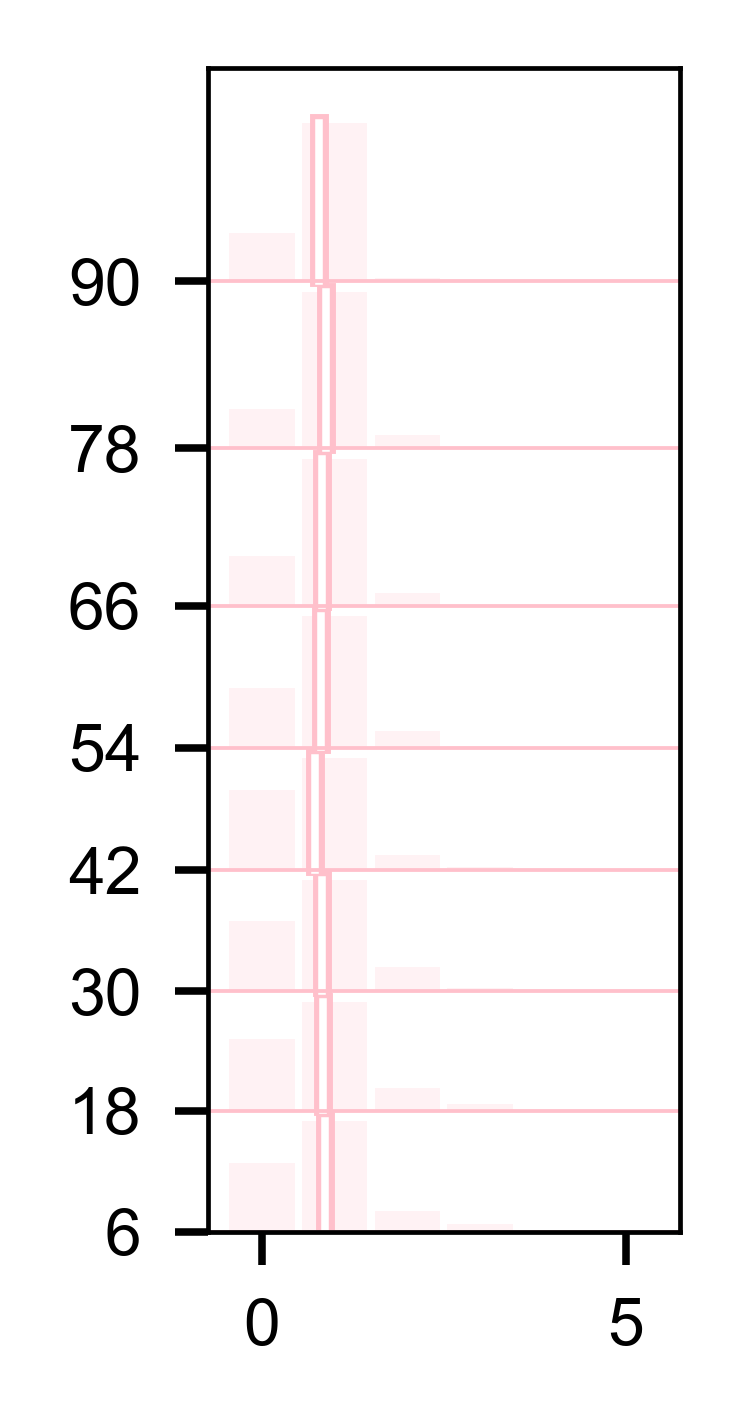

In [43]:
bin_size = 1
bin_end = 6
bins = np.arange(0,bin_end+bin_size,bin_size)
lw = 2
color = 'pink'

offset = 0

figure(None, (1.2,2.2), dpi=340)
ax = plt.gca()
ytix = []
for q in quantiles:
    ytix.append(offset)
    s = quant2domaincount_dodo[q]

    X = np.histogram(s,bins=bins)
    plt.bar(bins[:-1], X[0],width=bin_size*0.9, bottom=offset, alpha=0.2, color=color)

    average_val = np.mean(s)
    plt.plot([average_val, average_val], [offset+lw*4, offset+max(X[0])],color=color,lw=lw)
    plt.plot([average_val, average_val], [offset+0.5*2, offset+max(X[0])],color='w',lw=0.8)

    ax.axhline(offset, lw=0.4,color=color)
    offset = offset + max(X[0])+20
    
    
#plt.xlim([0,150])
plt.yticks(ytix, quantiles,fontsize=7)
plt.xticks(fontsize=7)
plt.tight_layout()

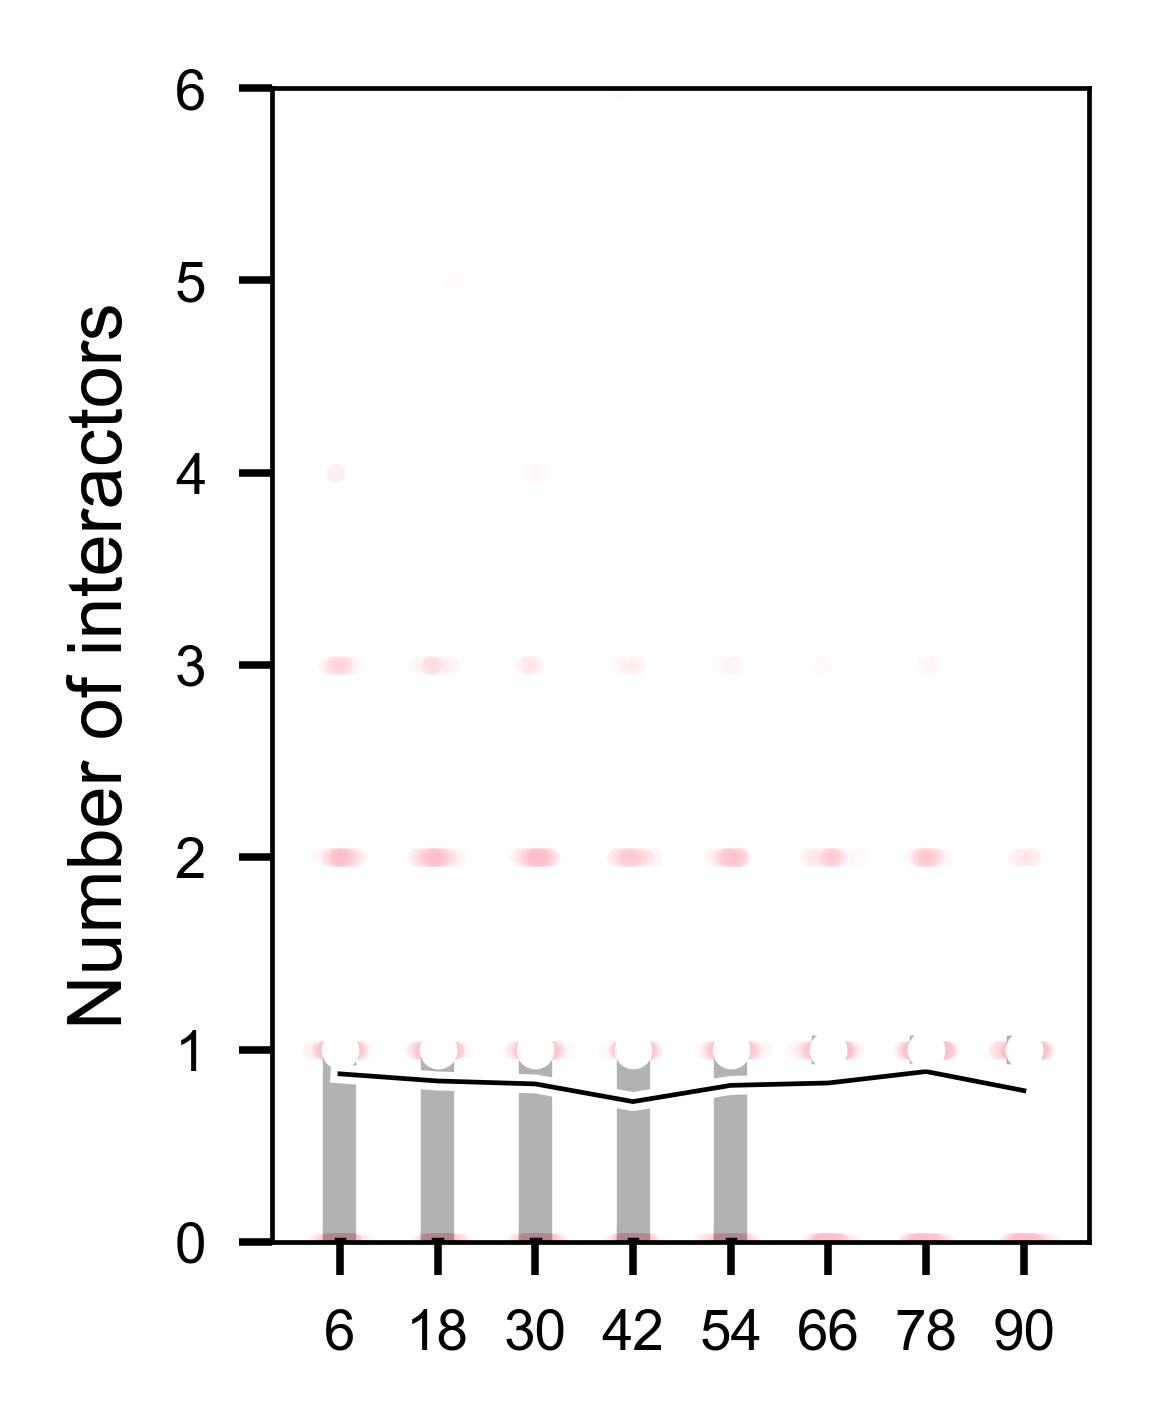

In [44]:
color='pink'
figure(None, (1.8,2.2), dpi=340)
boxprops = dict(linewidth=3,alpha=0.3, color='k')

plt.plot(quantiles, quant2domaincount_dodo_mean_scores,color='w',lw=2,zorder=20)
plt.plot(quantiles, quant2domaincount_dodo_mean_scores,color='k',lw=0.5,zorder=20)

all_s = []
for idx, name in enumerate(quantiles):
    s = quant2domaincount_dodo_scores[name]
    pos = quantiles[idx]
    scatter_pos = np.random.randn(len(s))*1.1+pos
    plt.scatter(scatter_pos, s, s=4, alpha=0.08, c=color,linewidth=0)

    b = plt.boxplot(s, positions=[pos],widths=[0.6],showfliers=False, whis=0, boxprops=boxprops,medianprops=boxprops, )
    all_s.extend(s)
plt.ylim([0,6])   
plt.yticks(fontsize=7)
plt.ylabel('Number of interactors', fontsize=8)

plt.plot(quantiles, quant2domaincount_dodo_median_scores,'o',color='w', zorder=20,ms=3)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()

In [45]:

d1 = []
d2 = []
d_s_over_t_mean = []
d_q = []


f2 = 'copy_number'
#f1 = 'num_disordered_res'
f1 = 'interact_count'

for p in yp:
    if f1 in p.attributes and f2 in p.attributes:
        d1.append(p.attribute(f1))
        d2.append(p.attribute(f2))
        d_q.append(p.attribute('quantile'))
        d_s_over_t_mean.append(p.attribute('S_over_T_mean'))
        
        
  
    

In [46]:
np.max(d1)

2603.0

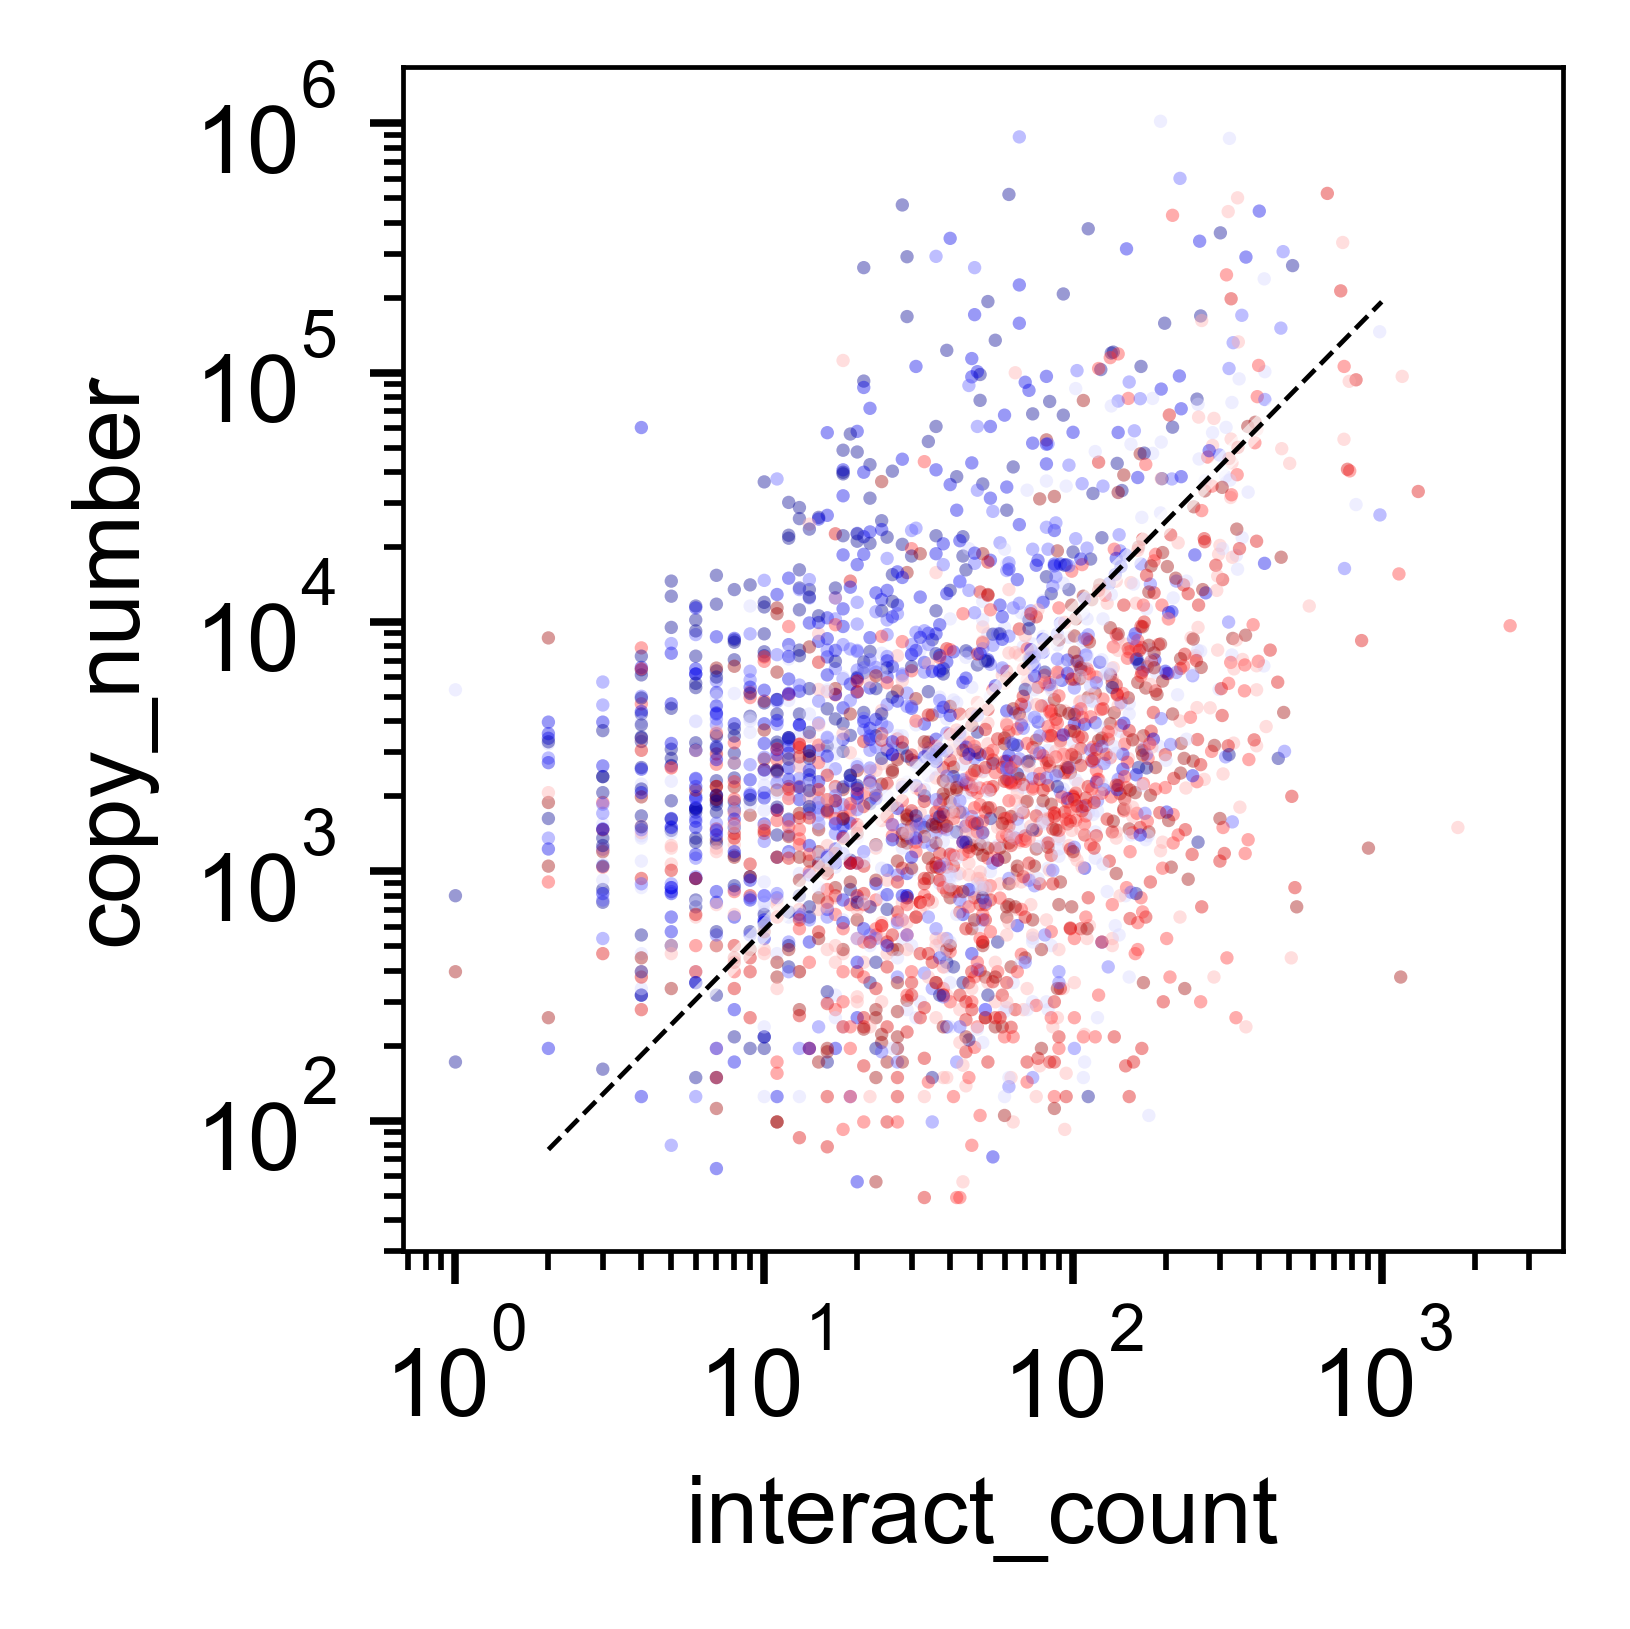

In [47]:
figure(None, (2.5,2.5), dpi=340)
plt.scatter(d1,d2,c=d_q, alpha=0.4,s=2,lw=0,cmap='seismic_r', vmax=100, vmin=0)
#plt.colorbar()
plt.yscale('log')
plt.xscale('log')
plt.xlabel(f1)
plt.ylabel(f2)
#plt.plot([2, 4000],[70,1000000],'-w',lw=2)
#plt.plot([2, 4000],[70,1000000],'--k',lw=0.5)

x_vals = np.arange(2,1000)

# empirical log relationship
y_vals = 32*np.power(x_vals, 1.26)


plt.plot(x_vals, y_vals,'-w',lw=2, alpha=.6)
plt.plot(x_vals, y_vals,'--k',lw=0.5)
plt.tight_layout()
plt.savefig('outfigures/copy_vs_inter_cbar.pdf')

#plt.plot([1],[1],'o-')
#plt.ylim([0.1,100000])
#plt.xlim([0.1,100000])